<center><h1>Quantifying Uncertainty</h1></center>
<center><h1>in Deep Learning Models</h1></center>

<center>Michelle Laubinger</center>
<center>Johann Sonnenburg</center>

<center>Applied Predictive Analytics</center>
<center>Summer 2022</center>

### Variational Inference (ADVI) Model Implementation


In [2]:

from google.colab import drive
drive.mount('/content/drive')
#import sys
#ys.path.append('/content/drive/MyDrive/APA')
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [4]:
## read in preprocessed data
X_resampled = pd.read_csv("data/X_resampled.csv")
y_resampled = pd.read_csv("data/y_resampled.csv")
X_val = pd.read_csv("data/X_val.csv")
y_val = pd.read_csv("data/y_val.csv")

In [5]:
from warnings import filterwarnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import sklearn
import theano
import theano.tensor as T
import theano.tensor.nnet as tt

from sklearn import datasets
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from theano.graph.op import Apply, config, Variable
from theano import shared
from theano.sandbox.multinomial import MultinomialFromUniform
from theano.graph.op import Op
from theano.graph.opt import local_optimizer
from theano.graph.params_type import ParamsType
from pymc3.theanof import set_tt_rng
from pymc3.variational.callbacks import CheckParametersConvergence

#### Random Number generator from Theano

In [6]:
"""
Implementation of MRG31k3p random number generator for Theano.

Generator code in SSJ package (L'Ecuyer & Simard).
http://www.iro.umontreal.ca/~simardr/ssj/indexe.html

The MRG31k3p algorithm was published in:

P. L'Ecuyer and R. Touzin, Fast Combined Multiple Recursive Generators with Multipliers of the form a = +/- 2^d +/- 2^e, Proceedings of the 2000 Winter Simulation Conference, Dec. 2000, 683-689.

The conception of the multi-stream from MRG31k3p was published in:

P. L'Ecuyer and R. Simard and E. Jack Chen and W. David Kelton, An Object-Oriented Random-Number Package with Many Long Streams and Substreams, Operations Research, volume 50, number 6, 2002, 1073-1075.
"""
from __future__ import absolute_import, print_function, division
import warnings

import numpy as np
from six import integer_types, string_types
from six.moves import xrange

import theano
#from theano import Apply, shared, config, Variable
from theano import gradient, function
from theano.gradient import undefined_grad
from theano import tensor
from theano.tensor import (TensorType, as_tensor_variable, get_vector_length,
                           cast, opt, scal)
from theano.compile import optdb
#from theano.graph.opt import local_optimizer, ParamsType
from theano.scalar import bool as bool_t, int32 as int_t
#from . import multinomial


def matVecModM(A, s, m):
    # TODO : need description for method, parameter and return
    assert A.dtype == 'int64'
    return np.int32(np.sum((A * s) % m, 1) % m)


def multMatVect(v, A, m1, B, m2):
    # TODO : need description for parameter and return
    """
    Multiply the first half of v by A with a modulo of m1 and the second half
    by B with a modulo of m2.

    Notes
    -----
    The parameters of dot_modulo are passed implicitly because passing them
    explicitly takes more time than running the function's C-code.

    """
    if multMatVect.dot_modulo is None:
        A_sym = tensor.lmatrix('A')
        s_sym = tensor.ivector('s')
        m_sym = tensor.iscalar('m')
        A2_sym = tensor.lmatrix('A2')
        s2_sym = tensor.ivector('s2')
        m2_sym = tensor.iscalar('m2')
        o = DotModulo()(A_sym, s_sym, m_sym, A2_sym, s2_sym, m2_sym)
        multMatVect.dot_modulo = function(
            [A_sym, s_sym, m_sym, A2_sym, s2_sym, m2_sym], o, profile=False)

    # This way of calling the Theano fct is done to bypass Theano overhead.
    f = multMatVect.dot_modulo
    f.input_storage[0].storage[0] = A
    f.input_storage[1].storage[0] = v[:3]
    f.input_storage[2].storage[0] = m1
    f.input_storage[3].storage[0] = B
    f.input_storage[4].storage[0] = v[3:]
    f.input_storage[5].storage[0] = m2
    f.fn()
    r = f.output_storage[0].storage[0]

    return r
multMatVect.dot_modulo = None


class DotModulo(Op):
    """
    Efficient and numerically stable implementation of a dot product followed
    by a modulo operation. This performs the same function as matVecModM.

    We do this 2 times on 2 triple inputs and concatenating the output.

    """
    __props__ = ()

    def make_node(self, A, s, m, A2, s2, m2):
        return Apply(self, [A, s, m, A2, s2, m2], [s.type()])

    def perform(self, node, inputs, outputs):
        (A, s, m, A2, s2, m2) = inputs
        (out,) = outputs
        o1 = matVecModM(A, s, m)
        o2 = matVecModM(A2, s2, m2)
        out[0] = np.concatenate((o1, o2))

    def c_code_cache_version(self):
        return (6,)

    def c_code(self, node, name, inputs, outputs, sub):
        (_A, _s, _m, _A2, _s2, _m2) = inputs
        (_z,) = outputs
        return """
        int osize = -1;
        if (PyArray_NDIM(%(_A)s) != 2) {PyErr_SetString(PyExc_NotImplementedError, "rank(A) != 2"); %(fail)s;}
        if (PyArray_NDIM(%(_s)s) != 1) {PyErr_SetString(PyExc_NotImplementedError, "rank(v) != 1"); %(fail)s;}
        if (PyArray_NDIM(%(_m)s) != 0) {PyErr_SetString(PyExc_NotImplementedError, "rank(m) != 0"); %(fail)s;}
        if (PyArray_NDIM(%(_A2)s) != 2) {PyErr_SetString(PyExc_NotImplementedError, "rank(A2) != 2"); %(fail)s;}
        if (PyArray_NDIM(%(_s2)s) != 1) {PyErr_SetString(PyExc_NotImplementedError, "rank(v2) != 1"); %(fail)s;}
        if (PyArray_NDIM(%(_m2)s) != 0) {PyErr_SetString(PyExc_NotImplementedError, "rank(m2) != 0"); %(fail)s;}

        if( PyArray_DIMS(%(_A)s)[1] != PyArray_DIMS(%(_s)s)[0])
        {PyErr_SetString(PyExc_NotImplementedError, "A and s shapes don't agree."); %(fail)s;}
        if( PyArray_DIMS(%(_A2)s)[1] != PyArray_DIMS(%(_s2)s)[0])
        {PyErr_SetString(PyExc_NotImplementedError, "A2 and s2 shapes don't agree."); %(fail)s;}

        osize = PyArray_DIMS(%(_A)s)[0] + PyArray_DIMS(%(_A2)s)[0];
        if (!%(_z)s
            || (PyArray_DIMS(%(_z)s)[0] != osize))
        {
            {Py_XDECREF(%(_z)s);}
            npy_intp dims[] = {0,};
            dims[0] = osize;
            %(_z)s = (PyArrayObject*) PyArray_SimpleNew(1, dims, PyArray_TYPE(%(_s)s));
        }

        if(!%(_z)s){%(fail)s;}

        {   //makes it compile even though labels jump over variable definitions.

            // A has size MxN, s has N, output M
            npy_intp M = PyArray_DIMS(%(_A)s)[0];
            npy_intp N = PyArray_DIMS(%(_A)s)[1];

            const dtype_%(_A)s* __restrict__ DA = (dtype_%(_A)s*)PyArray_DATA(%(_A)s);
            dtype_%(_s)s* __restrict__ Ds = (dtype_%(_s)s*)PyArray_DATA(%(_s)s);
            dtype_%(_z)s* __restrict__ Dz = (dtype_%(_z)s*)PyArray_DATA(%(_z)s);
            const dtype_%(_m)s m = ((dtype_%(_m)s*)PyArray_DATA(%(_m)s))[0];

            npy_intp SA = PyArray_STRIDES(%(_A)s)[1] / PyArray_DESCR(%(_A)s)->elsize;
            npy_intp Ss = PyArray_STRIDES(%(_s)s)[0] / PyArray_DESCR(%(_s)s)->elsize;
            npy_intp Sz = PyArray_STRIDES(%(_z)s)[0] / PyArray_DESCR(%(_z)s)->elsize;

            for (npy_int32 i = 0; i < M; ++i)
            {
                const dtype_%(_A)s* __restrict__ Ak = (dtype_%(_A)s*)(PyArray_BYTES(%(_A)s) + PyArray_STRIDES(%(_A)s)[0] * i);

                npy_int64 r = 0;

                for (npy_int32 j = 0; j < N; ++j)
                {
                    r += (npy_int64)(Ds[j * Ss] * (npy_int64)(Ak[j * SA])) %% m;
                }

                Dz[i * Sz] = r %% m;
            }
        }

        //redo it with the second triple of inputs
        {
            // A has size MxN, s has N, output M
            npy_intp M = PyArray_DIMS(%(_A2)s)[0];
            npy_intp N = PyArray_DIMS(%(_A2)s)[1];

            const dtype_%(_A2)s* __restrict__ DA = (dtype_%(_A2)s*)PyArray_DATA(%(_A2)s);
            dtype_%(_s2)s* __restrict__ Ds = (dtype_%(_s2)s*)PyArray_DATA(%(_s2)s);
            const dtype_%(_m2)s m = ((dtype_%(_m2)s*)PyArray_DATA(%(_m2)s))[0];

            npy_intp SA = PyArray_STRIDES(%(_A2)s)[1] / PyArray_DESCR(%(_A2)s)->elsize;
            npy_intp Ss = PyArray_STRIDES(%(_s2)s)[0] / PyArray_DESCR(%(_s2)s)->elsize;
            npy_intp Sz = PyArray_STRIDES(%(_z)s)[0] / PyArray_DESCR(%(_z)s)->elsize;

            dtype_%(_z)s* __restrict__ Dz = (dtype_%(_z)s*)PyArray_DATA(%(_z)s) + PyArray_DIMS(%(_A)s)[0] * Sz;

            for (npy_int32 i = 0; i < M; ++i)
            {
                const dtype_%(_A2)s* __restrict__ Ak = (dtype_%(_A2)s*)(PyArray_BYTES(%(_A2)s) + PyArray_STRIDES(%(_A2)s)[0] * i);

                npy_int64 r = 0;

                for (npy_int32 j = 0; j < N; ++j)
                {
                    r += (npy_int64)(Ds[j * Ss] * (npy_int64)(Ak[j * SA])) %% m;
                }

                Dz[i * Sz] = r %% m;
            }

        }

        """ % dict(locals(), **sub)


# MRG31k3p
# generator constants :
M1 = np.asarray(np.int32(2147483647))       # 2^31 - 1
M2 = np.asarray(np.int32(2147462579))       # 2^31 - 21069
MASK12 = np.int32(511)                      # 2^9 - 1
MASK13 = np.int32(16777215)                 # 2^24 - 1
MASK2 = np.int32(65535)                     # 2^16 - 1
MULT2 = np.int32(21069)
NORM = 4.656612873077392578125e-10  # 1./2^31

# A1p0 = np.asarray([[0, 4194304, 129], [1, 0, 0], [0, 1, 0]],
#                      dtype='int64')
# A2p0 = np.asarray([[32768, 0, 32769], [1, 0, 0], [0, 1, 0]],
#                      dtype='int64')

A1p72 = np.asarray([[1516919229, 758510237, 499121365],
                    [1884998244, 1516919229, 335398200],
                    [601897748, 1884998244, 358115744]],
                   dtype='int64')
A2p72 = np.asarray([[1228857673, 1496414766, 954677935],
                    [1133297478, 1407477216, 1496414766],
                    [2002613992, 1639496704, 1407477216]],
                   dtype='int64')

A1p134 = np.asarray(
    [[1702500920, 1849582496, 1656874625],
     [828554832, 1702500920, 1512419905],
     [1143731069, 828554832, 102237247]],
    dtype='int64')
A2p134 = np.asarray(
    [[796789021, 1464208080, 607337906],
     [1241679051, 1431130166, 1464208080],
     [1401213391, 1178684362, 1431130166]],
    dtype='int64')
np_int32_vals = [np.int32(i) for i in (0, 7, 9, 15, 16, 22, 24)]


def ff_2p134(rstate):
    # TODO : need description for method, parameter and return
    return multMatVect(rstate, A1p134, M1, A2p134, M2)


def ff_2p72(rstate):
    # TODO : need description for method, parameter and return
    return multMatVect(rstate, A1p72, M1, A2p72, M2)


def mrg_next_value(rstate, new_rstate, NORM, mask, offset):
    # TODO : need description for method, parameter and return
    x11, x12, x13, x21, x22, x23 = rstate
    assert type(x11) == np.int32

    i0, i7, i9, i15, i16, i22, i24 = np_int32_vals
    # first component
    y1 = (((x12 & MASK12) << i22) + (x12 >> i9) +
          ((x13 & MASK13) << i7) + (x13 >> i24))

    assert type(y1) == np.int32
    if (y1 < 0 or y1 >= M1):  # must also check overflow
        y1 -= M1
    y1 += x13
    if (y1 < 0 or y1 >= M1):
        y1 -= M1

    x13 = x12
    x12 = x11
    x11 = y1

    # second component
    y1 = ((x21 & MASK2) << i15) + (MULT2 * (x21 >> i16))
    assert type(y1) == np.int32
    if (y1 < 0 or y1 >= M2):
        y1 -= M2
    y2 = ((x23 & MASK2) << i15) + (MULT2 * (x23 >> i16))
    assert type(y2) == np.int32
    if (y2 < 0 or y2 >= M2):
        y2 -= M2
    y2 += x23
    if (y2 < 0 or y2 >= M2):
        y2 -= M2
    y2 += y1
    if (y2 < 0 or y2 >= M2):
        y2 -= M2

    x23 = x22
    x22 = x21
    x21 = y2

    # Must never return either 0 or M1+1
    new_rstate[...] = [x11, x12, x13, x21, x22, x23]
    assert new_rstate.dtype == np.int32
    if (x11 <= x21):
        return (((x11 - x21 + M1) & mask) + offset) * NORM
    else:
        return (((x11 - x21) & mask) + offset) * NORM


class mrg_uniform_base(Op):
    # TODO : need description for class, parameter
    __props__ = ("output_type", "inplace")
    params_type = ParamsType(inplace=bool_t,
                             # following params will come from self.output_type.
                             # NB: As output object may not be allocated in C code,
                             # we can not be sure to get these properties from output.
                             # So, we should better get them as params from self.output_type.
                             ndim=int_t,
                             otypenum=int_t,
                             otype_is_float32=bool_t)

    def __init__(self, output_type, inplace=False):
        Op.__init__(self)
        self.output_type = output_type
        self.inplace = inplace
        if inplace:
            self.destroy_map = {0: [0]}
        self.warned_numpy_version = False

    # These attributes (used as params) are created as properties
    # to make them available even for old pickled objects, e.g.
    # when testing old interface or when using FAST_COMPILE mode.
    ndim = property(lambda self: self.output_type.ndim)
    otypenum = property(lambda self: np.dtype(self.output_type.dtype).num)
    otype_is_float32 = property(lambda self: self.output_type.dtype == 'float32')

    def __str__(self):
        if self.inplace:
            s = "inplace"
        else:
            s = "no_inplace"
        return self.__class__.__name__ + "{%s,%s}" % (self.output_type, s)

    def grad(self, inputs, ograd):
        return [gradient.grad_undefined(self, k, inp,
                                        'No gradient defined through '
                                        'random sampling op')
                for k, inp in enumerate(inputs)]

    def R_op(self, inputs, eval_points):
        return [None for i in eval_points]


class mrg_uniform(mrg_uniform_base):
    # CPU VERSION
    _f16_ok = True

    def make_node(self, rstate, size):
        # error checking slightly redundant here, since
        # this op should not be called directly.
        #
        # call through MRG_RandomStreams instead.
        broad = []
        for i in range(self.output_type.ndim):
                broad.append(tensor.extract_constant(size[i]) == 1)
        output_type = self.output_type.clone(broadcastable=broad)()
        rstate = as_tensor_variable(rstate)
        size = as_tensor_variable(size)
        return Apply(self,
                     [rstate, size],
                     [rstate.type(), output_type])

    @classmethod
    def new(cls, rstate, ndim, dtype, size):
        v_size = as_tensor_variable(size)
        if ndim is None:
            ndim = get_vector_length(v_size)
        op = cls(TensorType(dtype, (False,) * ndim))
        return op(rstate, v_size)

    def perform(self, node, inp, out, params):
        rstate, size = inp
        o_rstate, o_sample = out
        n_elements = 1
        for s in size:
            n_elements *= s
        if n_elements > M1:
            # The limit is on the C and GPU code. This perform don't
            # have this limit.  But to have all of them behave the
            # same (and have DebugMode don't use too much memory for
            # some rng_mrg tests) I also add this limit here.
            raise ValueError("rng_mrg does not support more then (2**31 -1) samples")

        rstate = np.asarray(rstate)  # bring state from GPU if necessary
        if not self.inplace:
            rstate = rstate.copy()

        n_streams, _ = rstate.shape

        rval = np.zeros(n_elements, dtype=self.output_type.dtype)
        if rval.dtype == 'float16':
            mask = 0x7fff
            offset = 1
            NORM = np.float16(3.0458e-05)
        elif rval.dtype == 'float32':
            mask = 0xffffffff
            offset = 0
            NORM = np.float32(4.6566126e-10)
        elif rval.dtype == 'float64':
            mask = 0xffffffff
            offset = 0
            NORM = 4.656612873077392578125e-10  # 1./2^31

        err_orig = np.seterr(over='ignore')
        try:
            for i in xrange(n_elements):
                sample = mrg_next_value(rstate[i % n_streams],
                                        rstate[i % n_streams],
                                        NORM=NORM, mask=mask, offset=offset)
                rval[i] = sample
        finally:
            np.seterr(**err_orig)

        # send to GPU if necessary
        o_rstate[0] = node.outputs[0].type.filter(rstate)
        o_sample[0] = node.outputs[1].type.filter(rval.reshape(size))

    def c_support_code(self):
        return "\n".join("""
        void cpu_rng_mrg_uniform_%(dtype)s(PyArrayObject* o_sample, PyArrayObject* o_rstate,
                                           npy_int64 n_elements, int n_streams) {
            const npy_int32 i0 = 0;
            const npy_int32 i7 = 7;
            const npy_int32 i9 = 9;
            const npy_int32 i15 = 15;
            const npy_int32 i16 = 16;
            const npy_int32 i22 = 22;
            const npy_int32 i24 = 24;

            const npy_int32 M1 = 2147483647;      //2^31 - 1
            const npy_int32 M2 = 2147462579;      //2^31 - 21069
            const npy_int32 MASK12 = 511;       //2^9 - 1
            const npy_int32 MASK13 = 16777215;  //2^24 - 1
            const npy_int32 MASK2 = 65535;      //2^16 - 1
            const npy_int32 MULT2 = 21069;

            %(dtype)s* sample_data = (%(dtype)s *) PyArray_DATA(o_sample);
            npy_int32* state_data = (npy_int32 *) PyArray_DATA(o_rstate);
            for (int i = 0; i < n_elements; ++i)
            {
                npy_int32 * state_data_i = state_data + (i%%n_streams)*6;
                npy_int32 y1, y2, x11, x12, x13, x21, x22, x23;

                x11 = state_data_i[0];
                x12 = state_data_i[1];
                x13 = state_data_i[2];
                x21 = state_data_i[3];
                x22 = state_data_i[4];
                x23 = state_data_i[5];

                y1 = ((x12 & MASK12) << i22) + (x12 >> i9) + ((x13 & MASK13) << i7) + (x13 >> i24);
                if ((y1 < 0 || y1 >= M1))     //must also check overflow
                    y1 -= M1;
                y1 += x13;
                if ((y1 < 0 or y1 >= M1))
                    y1 -= M1;
                x13 = x12;
                x12 = x11;
                x11 = y1;

                y1 = ((x21 & MASK2) << i15) + (MULT2 * (x21 >> i16));
                if (y1 < 0 || y1 >= M2)
                    y1 -= M2;
                y2 = ((x23 & MASK2) << i15) + (MULT2 * (x23 >> i16));
                if (y2 < 0 || y2 >= M2)
                    y2 -= M2;
                y2 += x23;
                if (y2 < 0 || y2 >= M2)
                    y2 -= M2;
                y2 += y1;
                if (y2 < 0 or y2 >= M2)
                    y2 -= M2;

                x23 = x22;
                x22 = x21;
                x21 = y2;

                if (x11 <= x21) {
                    assert((x11 - x21 + M1) <= M1);
                    sample_data[i] = (x11 - x21 + M1) * %(NORM)s;
                }
                else
                {
                    assert(x11 - x21 <= M1);
                    sample_data[i] = (x11 - x21) * %(NORM)s;
                }

                state_data_i[0]= x11;
                state_data_i[1]= x12;
                state_data_i[2]= x13;
                state_data_i[3]= x21;
                state_data_i[4]= x22;
                state_data_i[5]= x23;
            }
        }
        """ % dict(dtype=dtype, NORM=NORM) for dtype, NORM in (
            ('npy_float32', '4.6566126e-10f'),
            ('npy_float64', '4.656612873077392578125e-10')
        ))

    def c_code(self, node, name, inp, out, sub):
        # If we try to use the C code here with something else than a
        # TensorType, something is wrong (likely one of the GPU ops
        # not defining C code correctly).
        assert isinstance(node.inputs[0].type, TensorType)
        if self.output_type.dtype == 'float16':
            # C code is not tested, fall back to Python
            super(mrg_uniform, self).c_code(node, name, inp, out, sub)
        return """
        //////// <code generated by mrg_uniform>
        npy_int64 odims_i;
        npy_int64 n_elements = 1;
        int n_streams = 0;
        int must_alloc_sample = ((NULL == %(o_sample)s)
                                 || (PyArray_NDIM(%(o_sample)s) != %(params)s->ndim)
                                 || !(PyArray_ISCONTIGUOUS(%(o_sample)s)));
        int o_rstate_requirement = %(params)s->inplace ?
                                    (NPY_ARRAY_C_CONTIGUOUS|NPY_ARRAY_ALIGNED) :
                                    (NPY_ARRAY_ENSURECOPY|NPY_ARRAY_C_CONTIGUOUS|NPY_ARRAY_ALIGNED);

        const npy_int32 i0 = 0;
        const npy_int32 i7 = 7;
        const npy_int32 i9 = 9;
        const npy_int32 i15 = 15;
        const npy_int32 i16 = 16;
        const npy_int32 i22 = 22;
        const npy_int32 i24 = 24;

        const npy_int32 M1 = 2147483647;      //2^31 - 1
        const npy_int32 M2 = 2147462579;      //2^31 - 21069
        const npy_int32 MASK12 = 511;       //2^9 - 1
        const npy_int32 MASK13 = 16777215;  //2^24 - 1
        const npy_int32 MASK2 = 65535;      //2^16 - 1
        const npy_int32 MULT2 = 21069;

        // We have to read size[i] as an int64, but odims has to be intp*
        // for NumPy on 32-bit platforms.
        npy_intp* odims = (npy_intp*)malloc(%(params)s->ndim * sizeof(npy_intp));
        if (odims == NULL) {
            PyErr_NoMemory();
            %(just_fail)s
        }

        if (PyArray_NDIM(%(size)s) != 1)
        {
            PyErr_SetString(PyExc_ValueError, "size must be vector");
            %(fail)s
        }
        if (PyArray_DIMS(%(size)s)[0] != %(params)s->ndim)
        {
            PyErr_Format(PyExc_ValueError, "size must have length %%i (not %%i)",
                %(params)s->ndim, int(PyArray_DIMS(%(size)s)[0]));
            %(fail)s
        }

        for (int i = 0; i < %(params)s->ndim; ++i)
        {
            odims_i = *(dtype_%(size)s *)PyArray_GETPTR1(%(size)s, i);
            odims[i] = odims_i;
            n_elements *= odims_i;
            must_alloc_sample = must_alloc_sample || (PyArray_DIMS(%(o_sample)s)[i] != odims[i]);
            //fprintf(stderr, "size %%i %%i\\n", i, (int)odims[i]);
            //printf("%%li", n_elements);
        }
        //fprintf(stderr, "n_elements %%lld\\n", (long long)n_elements);
        if (n_elements > M1)
        {
            PyErr_SetString(
                PyExc_ValueError,
                "rng_mrg cpu-implementation does not support more than (2**31 -1) samples");
            %(fail)s
        }

        if (must_alloc_sample)
        {
            Py_XDECREF(%(o_sample)s);
            %(o_sample)s = (PyArrayObject*)PyArray_SimpleNew(%(params)s->ndim, odims, %(params)s->otypenum);
            if(!%(o_sample)s) {
                PyErr_SetString(PyExc_MemoryError, "failed to alloc mrg_uniform output");
                %(fail)s
            }
        }
        Py_XDECREF(%(o_rstate)s);
        %(o_rstate)s = (PyArrayObject*)PyArray_FromAny(
            (PyObject*)%(rstate)s,
            NULL, 0, 0, o_rstate_requirement,NULL);

        if (PyArray_NDIM(%(o_rstate)s) != 2)
        {
            PyErr_SetString(PyExc_ValueError, "rstate must be matrix");
            %(fail)s
        }
        if (PyArray_DIMS(%(o_rstate)s)[1] != 6)
        {
            PyErr_Format(PyExc_ValueError, "rstate must have 6 columns");
            %(fail)s
        }
        if (PyArray_DESCR(%(o_rstate)s)->type_num != NPY_INT32)
        {
            PyErr_SetString(PyExc_ValueError, "rstate must be int32");
            %(fail)s
        }
        n_streams = PyArray_DIMS(%(o_rstate)s)[0];

        if (%(params)s->otype_is_float32) {
            cpu_rng_mrg_uniform_npy_float32(%(o_sample)s, %(o_rstate)s, n_elements, n_streams);
        } else {
            cpu_rng_mrg_uniform_npy_float64(%(o_sample)s, %(o_rstate)s, n_elements, n_streams);
        }

        free(odims);
        //////// </ code generated by mrg_uniform>
        """ % dict(rstate=inp[0], size=inp[1],
                   o_rstate=out[0], o_sample=out[1],
                   params=sub['params'],
                   just_fail=sub['fail'],
                   fail="""
                   {
                       free(odims);
                       %(fail)s
                   }
                   """ % dict(fail=sub['fail']))

    def c_code_cache_version(self):
        return (10,)


def guess_n_streams(size, warn=False):
    # TODO : need description for parameter 'size'
    """
    Return a guess at a good number of streams.

    Parameters
    ----------
    warn : bool, optional
        If True, warn when a guess cannot be made (in which case we
        return 60 * 256).

    """
    # TODO: a smart way of choosing the number of streams, see #612.
    # Note that this code was moved out of `MRG_RandomStreams` so that it can
    # be easily accessed from tests, where we want to disable the warning.
    if (isinstance(size, (tuple, list)) and
            all([isinstance(i, integer_types) for i in size])):
        # We can make a guess.
        r = 1
        for s in size:
            r *= s
        if r > 6:
            r = r // 6  # chosen as fastest for rbm_benchmark

        # The purpose of sampling from many streams is to be able to use
        # the GPU to its full capacity. It just wastes RAM and
        # stream-initialization time to allocate more streams than necessary
        # for the GPU.
        # XXX: This number is chosen to be good for 280 and 480 architectures,
        #      Better would be to use pycuda to query the number of
        #      processors on the GPU device,
        #      rather than guessing 60.
        return min(r, 60 * 256)
    else:
        if warn:
            warnings.warn(
                ("MRG_RandomStreams Can't determine #streams "
                 "from size (%s), guessing 60*256") % str(size),
                stacklevel=3)
        return 60 * 256


class MRG_RandomStreams(object):
    """
    Module component with similar interface to numpy.random
    (numpy.random.RandomState).

    Parameters
    ----------
    seed : int or list of 6 int
        A default seed to initialize the random state.
        If a single int is given, it will be replicated 6 times.
        The first 3 values of the seed must all be less than M1 = 2147483647,
        and not all 0; and the last 3 values must all be less than
        M2 = 2147462579, and not all 0.

    """

    def updates(self):
        # TODO : need description for method and return
        return list(self.state_updates)

    def __init__(self, seed=12345):
        # A list of pairs of the form (input_r, output_r), representing the
        # update rules of all the random states generated
        # by this RandomStreams.
        self.state_updates = []

        super(MRG_RandomStreams, self).__init__()

        # Needed to reset the streams.
        self.default_instance_seed = seed

        self.set_rstate(seed)

    def set_rstate(self, seed):
        # TODO : need description for method, parameter
        if isinstance(seed, integer_types):
            if seed == 0:
                raise ValueError('seed should not be 0', seed)
            elif seed >= M2:
                raise ValueError('seed should be less than %i' % M2, seed)
            self.rstate = np.asarray([seed] * 6, dtype='int32')
        elif len(seed) == 6:
            if seed[0] == 0 and seed[1] == 0 and seed[2] == 0:
                raise ValueError(
                    'The first 3 values of seed should not be all 0', seed)
            if seed[3] == 0 and seed[4] == 0 and seed[5] == 0:
                raise ValueError(
                    'The last 3 values of seed should not be all 0', seed)
            if seed[0] >= M1 or seed[1] >= M1 or seed[2] >= M1:
                raise ValueError(
                    'The first 3 values of seed should be less than %i' % M1,
                    seed)
            if seed[3] >= M2 or seed[4] >= M2 or seed[5] >= M2:
                raise ValueError(
                    'The last 3 values of seed should be less than %i' % M2,
                    seed)
            self.rstate = np.asarray(seed, dtype='int32')
        else:
            raise TypeError("seed should be 1 integer or 6 integers")

    def seed(self, seed=None):
        """
        Re-initialize each random stream.

        Parameters
        ----------
        seed : None or integer in range 0 to 2**30
            Each random stream will be assigned a unique state that depends
            deterministically on this value.

        Returns
        -------
        None

        """
        if seed is None:
            seed = self.default_instance_seed
        self.set_rstate(seed)

        for old_r, new_r, size, nstreams in self.state_updates:
            if nstreams is None:
                nstreams = self.n_streams(size)
            rstates = self.get_substream_rstates(nstreams,
                                                 new_r.owner.outputs[1].dtype)
            assert (old_r.get_value(borrow=True,
                                    return_internal_type=True).shape ==
                    rstates.shape)
            assert rstates.dtype == old_r.dtype
            old_r.set_value(rstates, borrow=True)

    def inc_rstate(self):
        """
        Update self.rstate to be skipped 2^134 steps forward to the next stream
        start.

        """
        # self.rstate = ff_2p134(self.rstate)
        self.rstate = multMatVect(self.rstate, A1p134, M1, A2p134, M2)
        assert self.rstate.dtype == np.int32

    @theano.change_flags(compute_test_value='off')
    def get_substream_rstates(self, n_streams, dtype, inc_rstate=True):
        # TODO : need description for parameter and return
        """
        Initialize a matrix in which each row is a MRG stream state,
        and they are spaced by 2**72 samples.

        """
        assert isinstance(dtype, string_types)
        assert n_streams < 2**72
        assert n_streams > 0
        rval = np.zeros((n_streams, 6), dtype='int32')
        rval[0] = self.rstate

        # If multMatVect.dot_modulo isn't compiled, compile it.
        if multMatVect.dot_modulo is None:
            multMatVect(rval[0], A1p72, M1, A2p72, M2)

        # This way of calling the Theano fct is done to bypass Theano overhead.
        f = multMatVect.dot_modulo
        f.input_storage[0].storage[0] = A1p72
        f.input_storage[2].storage[0] = M1
        f.input_storage[3].storage[0] = A2p72
        f.input_storage[5].storage[0] = M2
        for i in xrange(1, n_streams):
            # Inline the following call to bypass Python overhead
            # rval[i] = ff_2p72(rval[i - 1])
            v = rval[i - 1]
            f.input_storage[1].storage[0] = v[:3]
            f.input_storage[4].storage[0] = v[3:]
            f.fn()
            rval[i] = f.output_storage[0].storage[0]

        if inc_rstate:
            self.inc_rstate()

        return rval

    def n_streams(self, size):
        # TODO : need description for method, parameter and return
        return guess_n_streams(size)

    def pretty_return(self, node_rstate, new_rstate, sample, size, nstreams):
        # TODO : need description for method, parameter and return
        sample.rstate = node_rstate
        sample.update = (node_rstate, new_rstate)
        self.state_updates.append((node_rstate, new_rstate, size, nstreams))
        node_rstate.default_update = new_rstate
        return sample

    def uniform(self, size, low=0.0, high=1.0, ndim=None, dtype=None,
                nstreams=None, **kwargs):
        # TODO : need description for parameter 'size', 'ndim', 'nstreams'
        """
        Sample a tensor of given size whose element from a uniform
        distribution between low and high.

        If the size argument is ambiguous on the number of dimensions,
        ndim may be a plain integer to supplement the missing information.

        Parameters
        ----------
        low
            Lower bound of the interval on which values are sampled.
            If the ``dtype`` arg is provided, ``low`` will be cast into
            dtype. This bound is excluded.
        high
            Higher bound of the interval on which values are sampled.
            If the ``dtype`` arg is provided, ``high`` will be cast into
            dtype. This bound is excluded.
        size
          Can be a list of integer or Theano variable (ex: the shape
          of other Theano Variable).
        dtype
            The output data type. If dtype is not specified, it will be
            inferred from the dtype of low and high, but will be at
            least as precise as floatX.

        """
        low = as_tensor_variable(low)
        high = as_tensor_variable(high)

        if dtype is None:
            dtype = scal.upcast(config.floatX, low.dtype, high.dtype)

        low = cast(low, dtype=dtype)
        high = cast(high, dtype=dtype)

        low = undefined_grad(low)
        high = undefined_grad(high)

        if isinstance(size, tuple):
            msg = "size must be a tuple of int or a Theano variable"
            assert all([isinstance(i, (np.integer, integer_types, Variable))
                        for i in size]), msg
            if any([isinstance(i, (np.integer, integer_types)) and i <= 0
                    for i in size]):
                raise ValueError(
                    "The specified size contains a dimension with value <= 0",
                    size)

        else:
            if not (isinstance(size, Variable) and size.ndim == 1):
                raise TypeError("size must be a tuple of int or a Theano "
                                "Variable with 1 dimension, got " + str(size) +
                                " of type " + str(type(size)))
        orig_nstreams = nstreams
        if nstreams is None:
            nstreams = self.n_streams(size)
        rstates = self.get_substream_rstates(nstreams, dtype)

        d = {}
        if 'target' in kwargs:
            d = dict(target=kwargs.pop('target'))
        if len(kwargs) > 0:
            raise TypeError("uniform() got unexpected keyword arguments %s" % (str(kwargs.keys())))
        node_rstate = shared(rstates, **d)
        u = self.pretty_return(node_rstate,
                               *mrg_uniform.new(node_rstate,
                                                ndim, dtype, size),
                               size=size, nstreams=orig_nstreams)
        # Add a reference to distinguish from other shared variables
        node_rstate.tag.is_rng = True
        r = u * (high - low) + low

        if u.type.broadcastable != r.type.broadcastable:
            raise NotImplementedError(
                'Increase the size to match the broadcasting pattern of '
                '`low` and `high` arguments')

        assert r.dtype == dtype
        return r

    def binomial(self, size=None, n=1, p=0.5, ndim=None, dtype='int64',
                 nstreams=None, **kwargs):
        # TODO : need description for method, parameter and return
        if n == 1:
            p = undefined_grad(as_tensor_variable(p))
            x = self.uniform(size=size, nstreams=nstreams, **kwargs)
            return cast(x < p, dtype)
        else:
            raise NotImplementedError("MRG_RandomStreams.binomial with n > 1")

    def multinomial(self, size=None, n=1, pvals=None, ndim=None, dtype='int64',
                    nstreams=None, **kwargs):
        # TODO : need description for parameter and return
        """
        Sample `n` (`n` needs to be >= 1, default 1) times from a multinomial
        distribution defined by probabilities pvals.

        Example : pvals = [[.98, .01, .01], [.01, .49, .50]] and n=1 will
        probably result in [[1,0,0],[0,0,1]]. When setting n=2, this
        will probably result in [[2,0,0],[0,1,1]].

        Notes
        -----
        -`size` and `ndim` are only there keep the same signature as other
        uniform, binomial, normal, etc.
        TODO : adapt multinomial to take that into account

        -Does not do any value checking on pvals, i.e. there is no
        check that the elements are non-negative, less than 1, or
        sum to 1. passing pvals = [[-2., 2.]] will result in
        sampling [[0, 0]]

        """
        if pvals is None:
            raise TypeError("You have to specify pvals")
        pvals = as_tensor_variable(pvals)
        pvals = undefined_grad(pvals)
        if size is not None:
            if any([isinstance(i, integer_types) and i <= 0 for i in size]):
                raise ValueError(
                    "The specified size contains a dimension with value <= 0",
                    size)

        if size is not None:
            raise ValueError(
                "Provided a size argument to MRG_RandomStreams.multinomial, "
                "which does not use the size argument.")
        if ndim is not None:
            raise ValueError(
                "Provided an ndim argument to MRG_RandomStreams.multinomial, "
                "which does not use the ndim argument.")
        if pvals.ndim == 2:
            size = pvals[:, 0].shape * n
            unis = self.uniform(size=size, ndim=1, nstreams=nstreams, **kwargs)
            op = multinomial.MultinomialFromUniform(dtype)
            n_samples = as_tensor_variable(n)
            return op(pvals, unis, n_samples)
        else:
            raise NotImplementedError(("MRG_RandomStreams.multinomial only"
                                       " implemented for pvals.ndim = 2"))

    def choice(self, size=1, a=None, replace=True, p=None, ndim=None,
               dtype='int64', nstreams=None, **kwargs):
        """
        Sample `size` times from a multinomial distribution defined by
        probabilities `p`, and returns the indices of the sampled elements.
        Sampled values are between 0 and `p.shape[1]-1`.
        Only sampling without replacement is implemented for now.

        Parameters
        ----------
        size: integer or integer tensor (default 1)
            The number of samples. It should be between 1 and `p.shape[1]-1`.
        a: int or None (default None)
            For now, a should be None. This function will sample
            values between 0 and `p.shape[1]-1`. When a != None will be
            implemented, if `a` is a scalar, the samples are drawn from the
            range 0,...,a-1. We default to 2 as to have the same interface as
            RandomStream.
        replace: bool (default True)
            Whether the sample is with or without replacement.
            Only replace=False is implemented for now.
        p: 2d numpy array or theano tensor
            the probabilities of the distribution, corresponding to values
            0 to `p.shape[1]-1`.

        Example : p = [[.98, .01, .01], [.01, .49, .50]] and size=1 will
        probably result in [[0],[2]]. When setting size=2, this
        will probably result in [[0,1],[2,1]].

        Notes
        -----
        -`ndim` is only there keep the same signature as other
        uniform, binomial, normal, etc.

        -Does not do any value checking on pvals, i.e. there is no
        check that the elements are non-negative, less than 1, or
        sum to 1. passing pvals = [[-2., 2.]] will result in
        sampling [[0, 0]]

        -Only replace=False is implemented for now.

        """
        if replace:
            raise NotImplementedError(
                "MRG_RandomStreams.choice only works without replacement "
                "for now.")

        if a is not None:
            raise TypeError("For now, a has to be None in "
                            "MRG_RandomStreams.choice. Sampled values are "
                            "between 0 and p.shape[1]-1")

        if p is None:
            raise TypeError("For now, p has to be specified in "
                            "MRG_RandomStreams.choice.")
        p = as_tensor_variable(p)
        p = undefined_grad(p)

        if ndim is not None:
            raise ValueError("ndim argument to "
                             "MRG_RandomStreams.choice "
                             "is not used.")

        if p.ndim != 2:
            raise NotImplementedError(
                "MRG_RandomStreams.choice is only implemented for p.ndim = 2")

        shape = p[:, 0].shape * size
        unis = self.uniform(size=shape, ndim=1, nstreams=nstreams, **kwargs)
        op = multinomial.ChoiceFromUniform(odtype=dtype)
        return op(p, unis, as_tensor_variable(size))

    def multinomial_wo_replacement(self, size=None, n=1, pvals=None,
                                   ndim=None, dtype='int64', nstreams=None, **kwargs):
        warnings.warn('MRG_RandomStreams.multinomial_wo_replacement() is '
                      'deprecated and will be removed in the next release of '
                      'Theano. Please use MRG_RandomStreams.choice() instead.')
        assert size is None
        return self.choice(size=n, a=None, replace=False, p=pvals,
                           dtype=dtype, nstreams=nstreams, ndim=ndim, **kwargs)

    def normal(self, size, avg=0.0, std=1.0, ndim=None, dtype=None,
               nstreams=None, truncate=False, **kwargs):
        """
        Sample a tensor of values from a normal distribution.

        Parameters
        ----------
        size : int_vector_like
            Array dimensions for the output tensor.
        avg : float_like, optional
            The mean value for the truncated normal to sample from (defaults to 0.0).
        std : float_like, optional
            The standard deviation for the truncated normal to sample from (defaults to 1.0).
        truncate : bool, optional
            Truncates the normal distribution at 2 standard deviations if True (defaults to False).
            When this flag is set, the standard deviation of the result will be less than the one specified.
        ndim : int, optional
            The number of dimensions for the output tensor (defaults to None).
            This argument is necessary if the size argument is ambiguous on the number of dimensions.
        dtype : str, optional
            The data-type for the output tensor. If not specified,
            the dtype is inferred from avg and std, but it is at least as precise as floatX.
        kwargs
            Other keyword arguments for random number generation (see uniform).

        Returns
        -------
        samples : TensorVariable
            A Theano tensor of samples randomly drawn from a normal distribution.

        """
        size = _check_size(size)
        avg = undefined_grad(as_tensor_variable(avg))
        std = undefined_grad(as_tensor_variable(std))

        if dtype is None:
            dtype = scal.upcast(config.floatX, avg.dtype, std.dtype)

        avg = tensor.cast(avg, dtype=dtype)
        std = tensor.cast(std, dtype=dtype)

        # generate even number of uniform samples
        # Do manual constant folding to lower optiimizer work.
        if isinstance(size, tensor.Constant):
            n_odd_samples = size.prod(dtype='int64')
        else:
            n_odd_samples = tensor.prod(size, dtype='int64')
        n_even_samples = n_odd_samples + n_odd_samples % 2
        uniform = self.uniform((n_even_samples, ), low=0., high=1.,
                               ndim=1, dtype=dtype, nstreams=nstreams, **kwargs)

        # box-muller transform
        u1 = uniform[:n_even_samples // 2]
        u2 = uniform[n_even_samples // 2:]
        r = tensor.sqrt(-2.0 * tensor.log(u1))
        theta = np.array(2.0 * np.pi, dtype=dtype) * u2
        cos_theta, sin_theta = tensor.cos(theta), tensor.sin(theta)
        z0 = r * cos_theta
        z1 = r * sin_theta

        if truncate:
            # use valid samples
            to_fix0 = (z0 < -2.) | (z0 > 2.)
            to_fix1 = (z1 < -2.) | (z1 > 2.)
            z0_valid = z0[tensor.nonzero(~to_fix0)]
            z1_valid = z1[tensor.nonzero(~to_fix1)]

            # re-sample invalid samples
            to_fix0 = tensor.nonzero(to_fix0)[0]
            to_fix1 = tensor.nonzero(to_fix1)[0]
            n_fix_samples = to_fix0.size + to_fix1.size
            lower = tensor.constant(1. / np.e**2, dtype=dtype)
            u_fix = self.uniform((n_fix_samples, ), low=lower, high=1.,
                                 ndim=1, dtype=dtype, nstreams=nstreams, **kwargs)
            r_fix = tensor.sqrt(-2. * tensor.log(u_fix))
            z0_fixed = r_fix[:to_fix0.size] * cos_theta[to_fix0]
            z1_fixed = r_fix[to_fix0.size:] * sin_theta[to_fix1]

            # pack everything together to a useful result
            norm_samples = tensor.join(0, z0_valid, z0_fixed, z1_valid, z1_fixed)
        else:
            norm_samples = tensor.join(0, z0, z1)
        if isinstance(n_odd_samples, tensor.Variable):
            samples = norm_samples[:n_odd_samples]
        elif n_odd_samples % 2 == 1:
            samples = norm_samples[:-1]
        else:
            samples = norm_samples
        samples = tensor.reshape(samples, newshape=size, ndim=ndim)
        samples *= std
        samples += avg

        return samples

    def truncated_normal(self, size, avg=0.0, std=1.0,
                         ndim=None, dtype=None, nstreams=None, **kwargs):
        """
        Sample a tensor of values from a symmetrically truncated normal distribution.

        Parameters
        ----------
        size : int_vector_like
            Array dimensions for the output tensor.
        avg : float_like, optional
            The mean value for the truncated normal to sample from (defaults to 0.0).
        std : float_like, optional
            The standard deviation for the truncated normal to sample from (defaults to 1.0).
        ndim : int, optional
            The number of dimensions for the output tensor (defaults to None).
            This argument is necessary if the size argument is ambiguous on the number of dimensions.
        dtype : str, optional
            The data-type for the output tensor. If not specified,
            the dtype is inferred from avg and std, but it is at least as precise as floatX.
        kwargs
            Other keyword arguments for random number generation (see uniform).

        Returns
        -------
        samples : TensorVariable
            A Theano tensor of samples randomly drawn from a truncated normal distribution.

        See Also
        --------
        normal
        """
        # constant taken from scipy.stats.truncnorm.std(a=-2, b=2, loc=0., scale=1.)
        std = std / tensor.constant(.87962566103423978)
        return self.normal(size=size, avg=avg, std=std, truncate=True,
                           ndim=ndim, dtype=dtype, nstreams=nstreams, **kwargs)


def _check_size(size):
    """
    Canonicalise inputs to get valid output sizes for Theano tensors.

    Parameters
    ----------
    size : int_vector_like
        Some variable that could serve as the shape for a Theano tensor.
        This can be an int, a tuple of ints, a list of ints
        or a Theano Variable with similar properties.

    Returns
    -------
    size_var : int_vector
        A one-dimensional Theano variable encapsulating the given size.

    Raises
    ------
    ValueError
        If this method can not build a valid size from the input.
    """
    # non-tuple checks and scalar-to-tuple transform
    if isinstance(size, tensor.Variable):
        if size.ndim == 1:
            return size
        elif size.ndim == 0:
            return tensor.stack([size], ndim=1)
        else:
            raise ValueError("Theano variable must have 1 dimension to be a valid size.", size)
    elif isinstance(size, (np.integer, integer_types)):
        return tensor.constant([size], ndim=1)
    elif not isinstance(size, (tuple, list)):
        raise ValueError("Size must be a int, tuple, list or Theano variable.", size)

    # check entries of list or tuple
    for i in size:
        if isinstance(i, tensor.Variable):
            if i.ndim != 0:
                raise ValueError("Non-scalar Theano variable in size", size, i)
        elif isinstance(i, (np.integer, integer_types)):
            if i <= 0:
                raise ValueError("Non-positive dimensions not allowed in size.", size, i)
        else:
            raise ValueError("Only Theano variables and integers are allowed in a size-tuple.", size, i)

    return tensor.as_tensor_variable(size, ndim=1)


@local_optimizer((mrg_uniform_base,))
def mrg_random_make_inplace(node):

    op = node.op
    if isinstance(op, mrg_uniform_base) and not op.inplace:
        # op might be gpu version
        new_op = op.__class__(op.output_type, inplace=True)
        return new_op.make_node(*node.inputs).outputs
    return False

#optdb.register('random_make_inplace_mrg',
 #              opt.in2out(mrg_random_make_inplace, ignore_newtrees=True),
  #             99, 'fast_run', 'inplace')

#### Model

In [7]:
## reshape data for pymc
%config InlineBackend.figure_format = 'retina'
floatX = theano.config.floatX
filterwarnings("ignore")
sns.set_style("white")
set_tt_rng(MRG_RandomStreams(42))
X=X_resampled
Y=y_resampled['TARGET']
y_val=y_val['TARGET']
X_train=X_resampled.to_numpy()
X_train=X_train.astype(floatX)
X_val=X_val.to_numpy()
X_val=X_val.astype(floatX)
Y_train = Y.to_numpy()
Y_train = Y.astype(floatX)
Y_train=np.reshape(Y_train, (len(Y_train),))
Y_val=y_val.to_numpy()
Y_val=y_val.astype(floatX)
y_val=np.reshape(y_val, (len(y_val),))

#### Model specification
As mentioned earlier, we will be using a quite simple network structure with just 2 hidden layers. We initialize random weights in each layer. The Normal priors help with the regularization of the weights. 

In [8]:
def construct_nn(ann_input, ann_output):
    n_hidden = 32 #


    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden,n_hidden).astype(float)
    init_3 = np.random.randn(n_hidden,n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X.shape[1], n_hidden), testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal("w_1_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)

        # Weights from 2nd to 3rd layer
        weights_2_3 = pm.Normal("w_2_3", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_3)

        # Weights from hidden layer to output
        weights_3_out = pm.Normal("w_3_out", 0, sigma=1, shape=(n_hidden,), testval=init_out)

        # Build neural-network using tanh activation function
      #  act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
      #  act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
      #  act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))
        #build neural_network using relu activation function
        act_1 = tt.nnet.relu(pm.math.dot(ann_input, weights_in_1))
        act_2 = tt.nnet.relu(pm.math.dot(act_1, weights_1_2))
        act_3 = tt.nnet.relu(pm.math.dot(act_2, weights_2_3))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_3_out))
        #tt.nnet.relu

        # Binary classification -> Bernoulli likelihood
     #   logp = class_weights*pm.Bernoulli.dist(p=act_out).logp(Y_train.values)
     #   error = pm.Potential("error",logp)
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches 
                   )
        #pm.Potential('weights',weights*pm.Bernoulli.dist(p=out).logp(Y_train.values))
  #      logp = class_weights*pm.Bernoulli.dist(p=out).logp(Y_train.values)
   #     error = pm.Potential("error",logp)
    return neural_network

neural_network = construct_nn(X_train, Y_train)

#### ADVI
Having specified the model, we use the ADVI variational inference algorithm and fit the model. The plot of the objective function (ELBO) shows how the model fit improves over time.

In [9]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference, callbacks=[CheckParametersConvergence(every=100,diff='absolute',tolerance=1e-4)])
  

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 3.1491e+09


CPU times: user 3h 14min 4s, sys: 1h 4min 26s, total: 4h 18min 30s
Wall time: 2h 23min 21s


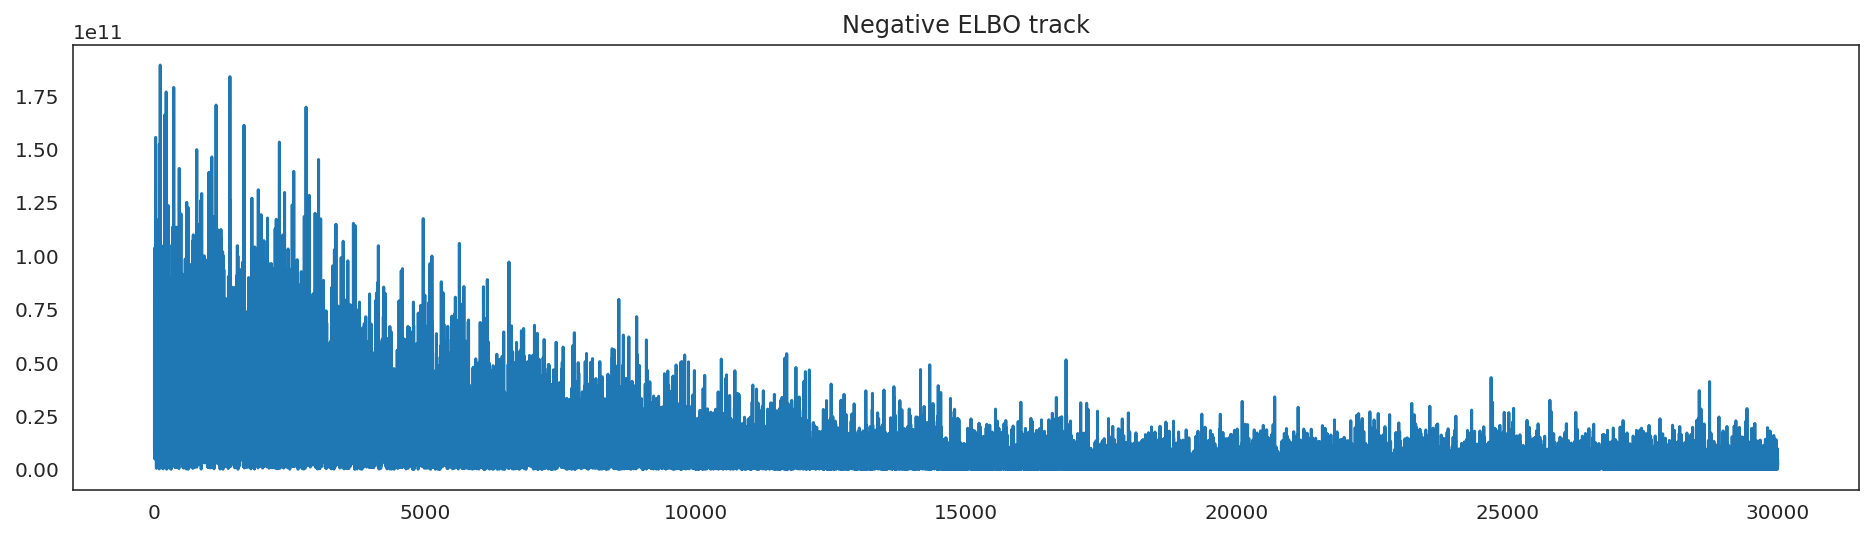

In [10]:
fig = plt.figure(figsize=(16, 9))
hist_ax = fig.add_subplot(212)
hist_ax.plot(inference.hist)
hist_ax.set_title("Negative ELBO track");

To test the model, we perform a posterior predictive check, by sampling from the estimated posterior. Essentially, we're generating data from our model and analysing how much that data deviates from the true distribution. 
The mean of the posterior predictive for each class label should be the same as the maximum likelihood predicted values. Using a BNN, we are also able to look at the standard deviation of the estimated posterior to get an idea about the uncertainty in our predictions. We can also have a look at the trace to see the uncertainty of our network weights. Lastly, we can also look at the posterior densities in more detail. 

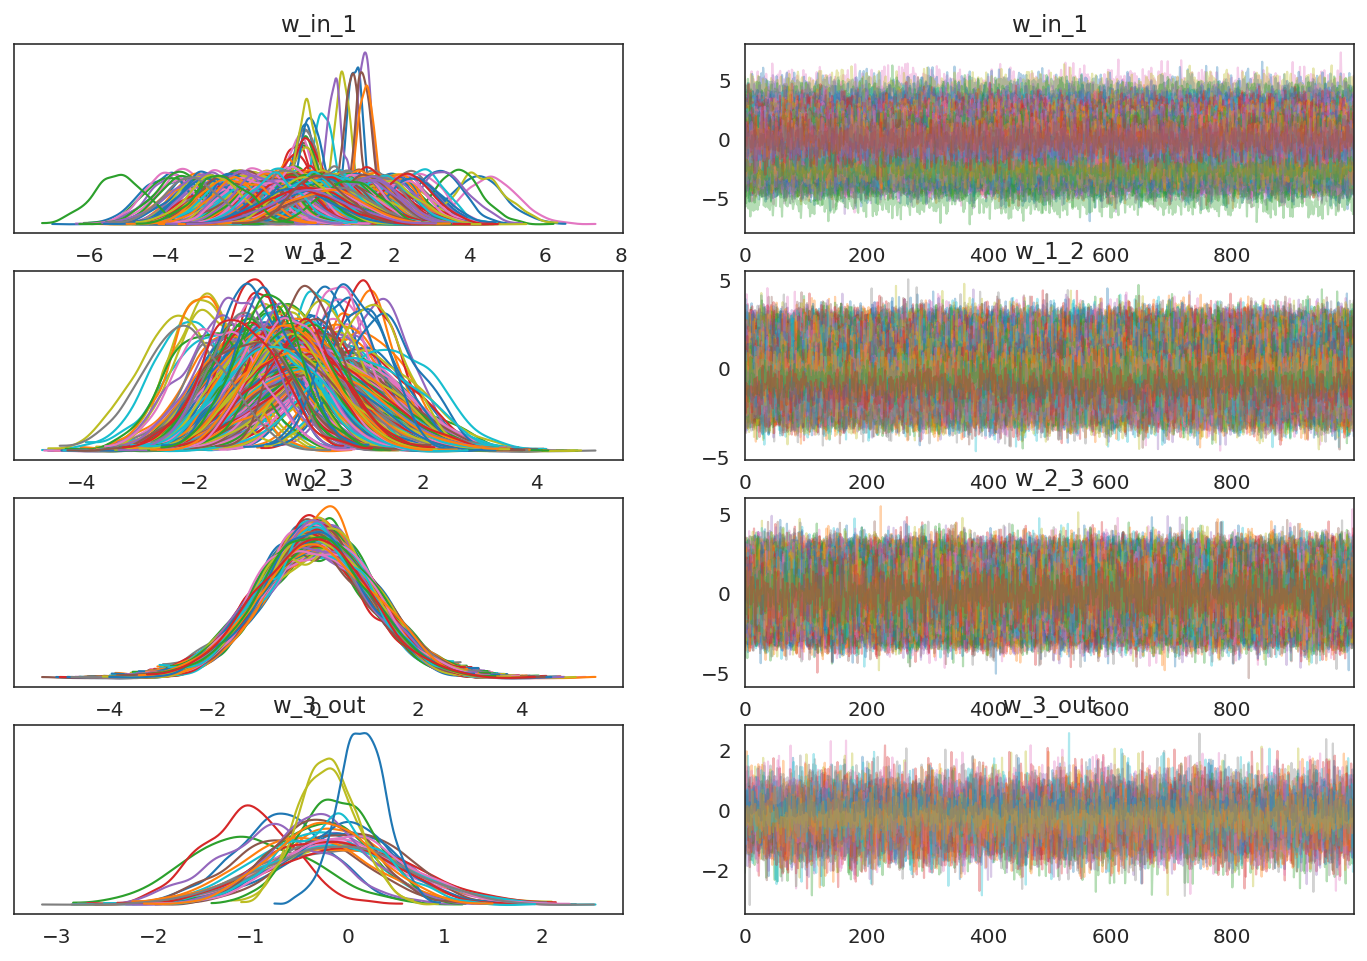

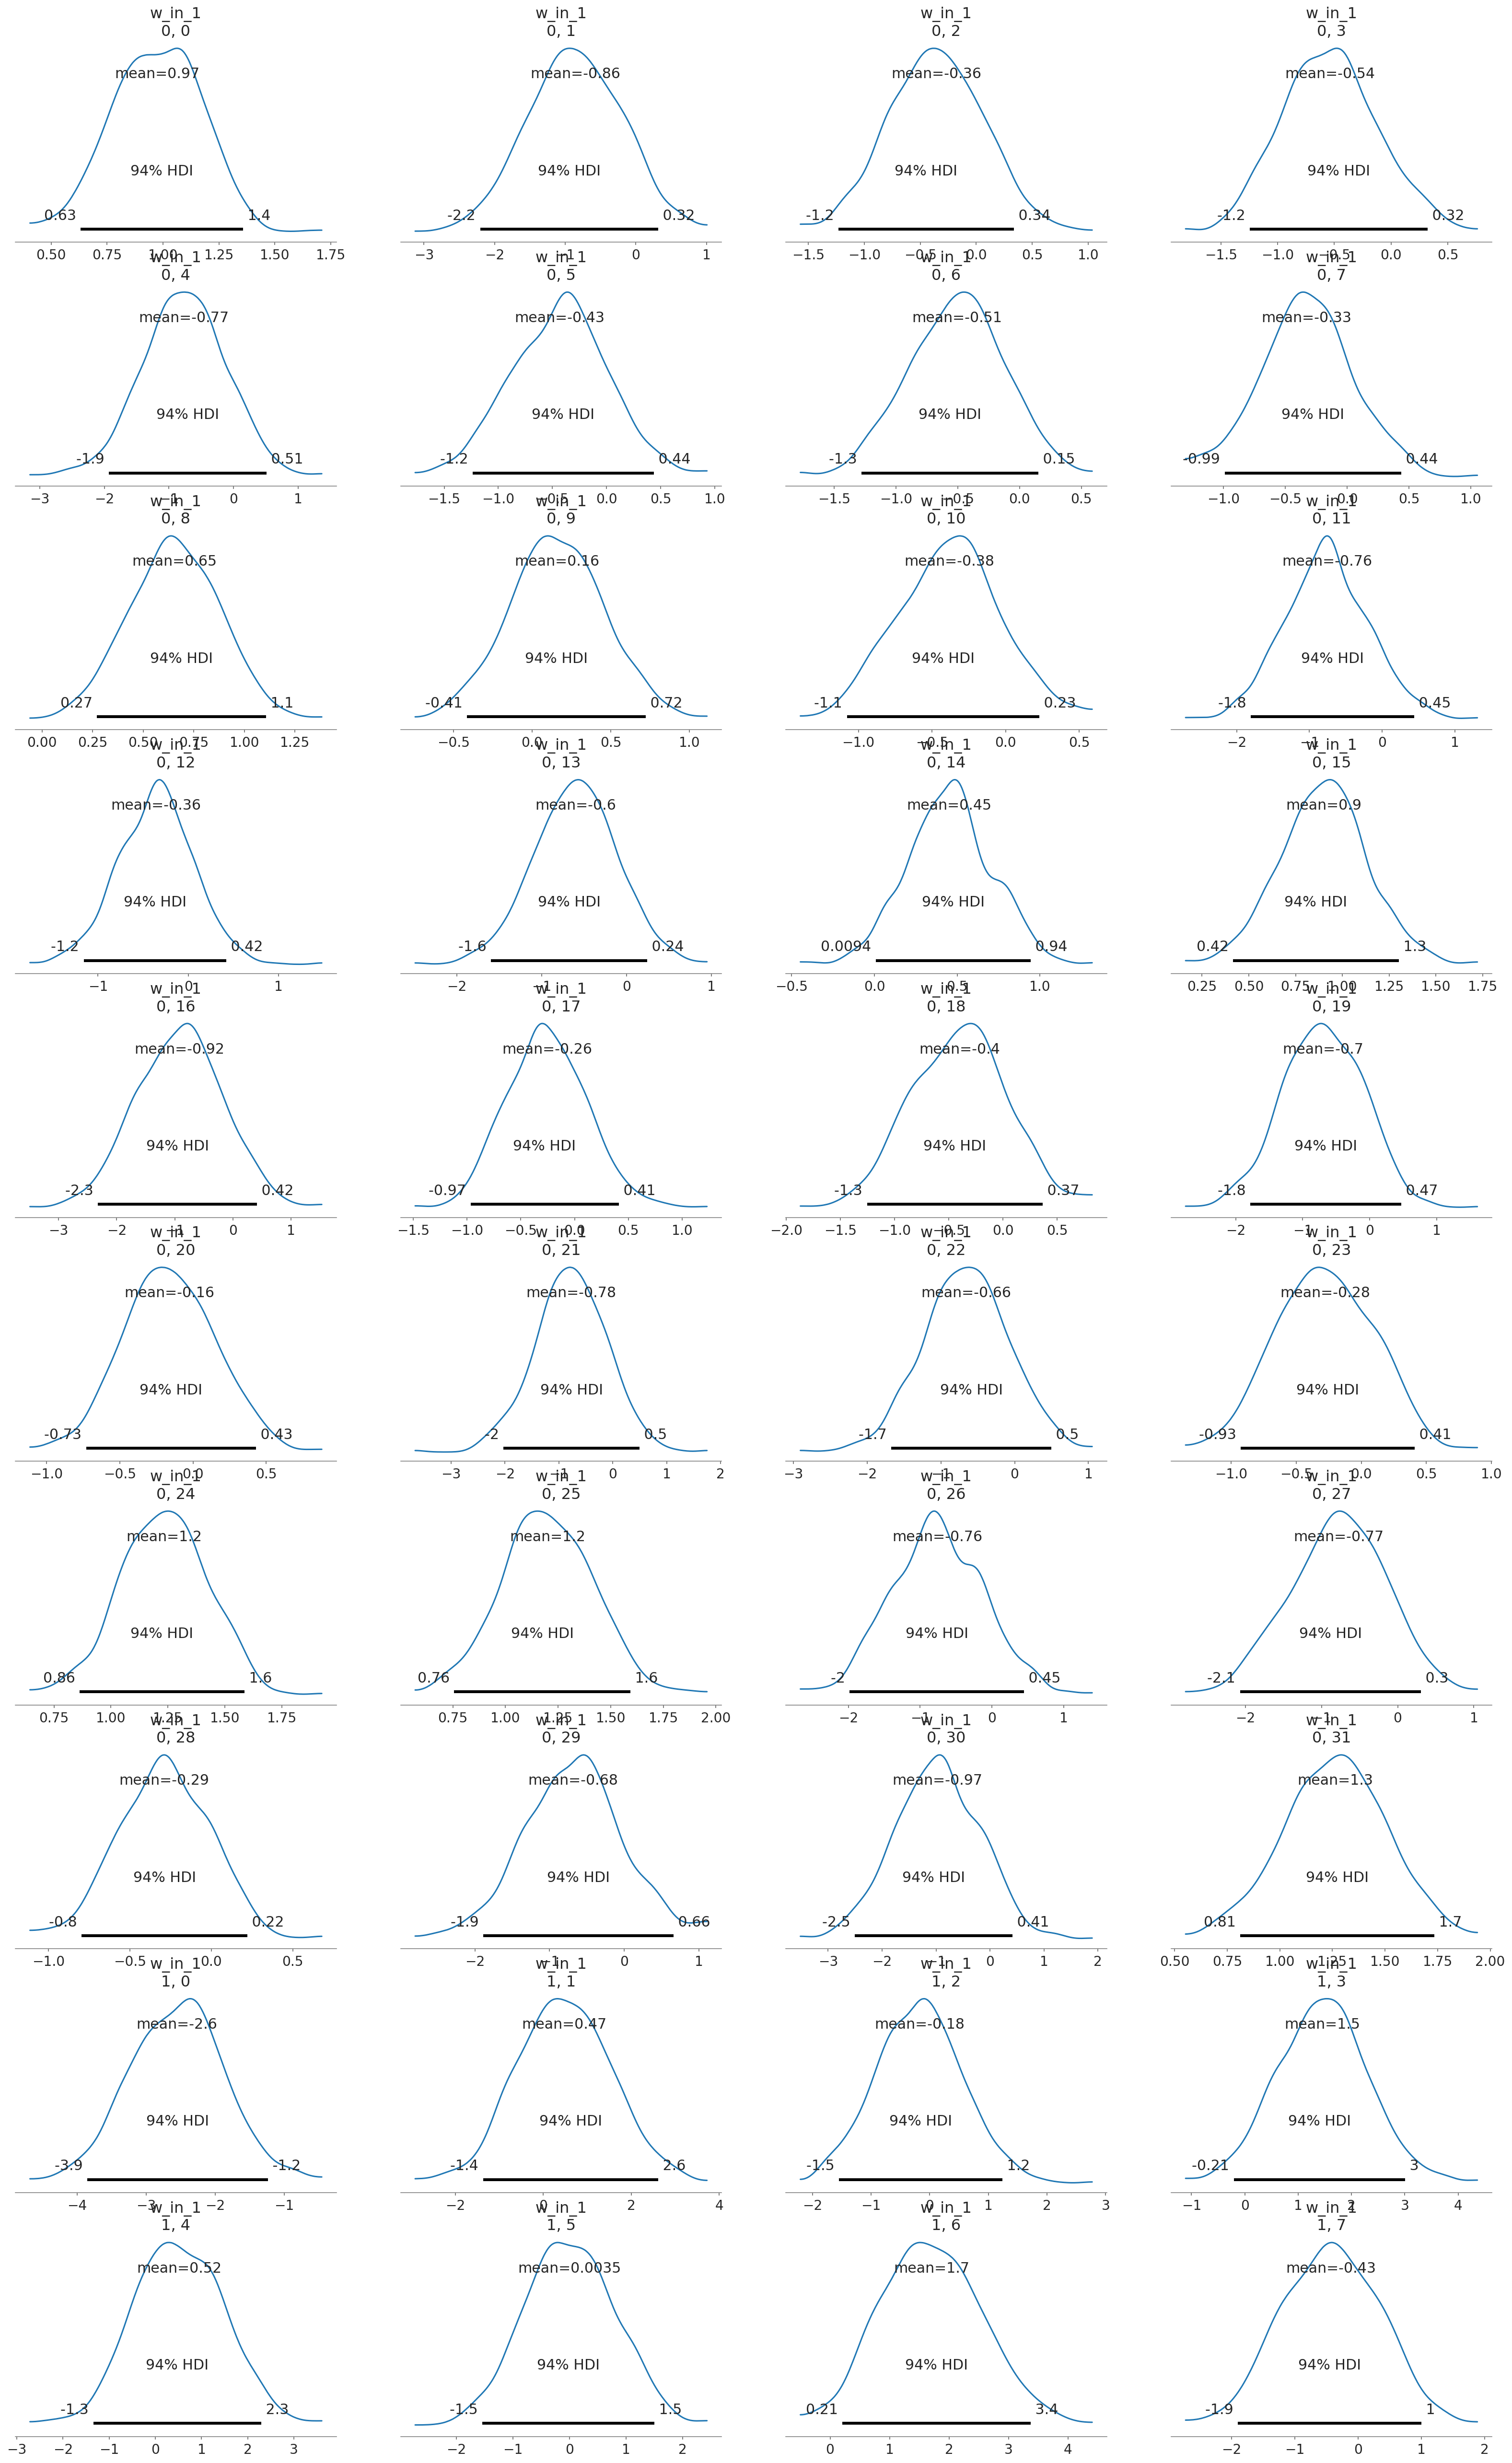

In [ ]:
with neural_network:
  inference = inference
  train_trace = pm.sample_approx(approx, draws=1000, include_transformed=True)
  pm.traceplot(train_trace)
  pm.plot_posterior(train_trace)
  ppc = pm.sample_posterior_predictive(train_trace)

In [11]:
with neural_network:
  inference = inference
  train_trace = pm.sample_approx(approx, draws=50000, include_transformed=True)
  pm.set_data(new_data={"ann_input": X_val, "ann_output": y_val})
  ppc = pm.sample_posterior_predictive(train_trace, samples=25000, progressbar=True)
  VI_pred = ppc["out"].mean(axis=0)

In [ ]:
VI_pred_prob=pd.DataFrame(VI_pred)
VI_pred_class = VI_pred_prob > 0.5
VI_pred_class.to_csv('classes.csv')